## Properties of inorganic chemical precursors

This Jupyter notebook cleans data imported from the CRC Handbook of Chemistry and Physics, 85th edition related to the solubility of various inorganic chemical compounds. It then attempts to visualize general trends about water solubility of various chemicals and match them with well-known solubility rules.

### Background

In my research, successful synthesis of single-phase oxide materials often depends on the chemical homogeneity of the precursor powder. The best method to obtain high homogeneity is often water-based synthesis where chemical precursors are dissolved and chelated to form a gel with atomic-level mixing of constituent elements. I often refer to the CRC Handbook to determine whether water-soluble precursors exist for the chemical compounds I am trying to create, and since this data is in a dense PDF table I wanted to see if I could take the data and make it easier to visualize what compounds tend to be water-soluble and which don't.

### Deliverables
1. A CSV file containing the cleaned data from the PDF table as well as additional columns stating the qualitative water solubilty and whether the compound is hydrated
2. A Python class/package for plotting the solubility of different kinds of chemical precursors

### Possible extensions
1. Other solvents rather than water.
2. Regression on quantitative solubility to predict for unknown compounds

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First, we read in the data from the CSV file. The CSV file was read in using Tabula, a PDF-reading software that converts PDF tables into tab-delimited files.

In [27]:
colNames = ['no', 'name', 'chemical_formula', 'CAS_no', 'mol_weight', 'physical_form', 'melting_point', 'boiling_point', 
            'density', 'solubility_per_100gH2O', 'qualitative_solubility', 'blanks']
df = pd.read_csv('tabula-Inorganic_solubility_with_lines.tsv', sep='\t', names=colNames)
df = df.drop(labels='blanks', axis=1)
print(df.shape)
print(df.no.tail(5))

(2740, 11)
2735    2677
2736    2678
2737    2679
2738    2680
2739    2681
Name: no, dtype: object


Ok, we're starting out with 2740 entries, but our chemicals are only numbered to 2681. Time to clean!

In [28]:
# Eliminate blank lines
df = df.dropna(axis=0, thresh=1)
df.shape

(2711, 11)

In [29]:
# Get rid of the header line that sometimes accompanies a new page
df = df[df.no != 'No.'] 
df.name = df.name.str.replace('\n', ' ')
print(df.shape)
print(df.iloc[:,:2].tail(5))
df = df.reset_index(drop=True)

(2681, 11)
        no                           name
2735  2677              Zirconium nitride
2736  2678            Zirconium phosphide
2737  2679             Zirconium silicide
2738  2680              Zirconyl chloride
2739  2681  Zirconyl chloride octahydrate


Great - now we have as many rows as we have chemicals. However, more cleaning is required - some of the reference footnotes in the solubility column have been read in as actual numbers! Let's make a function that tries to eliminate 2 significant digits from the end of the number and see whether the result is zero. If it is, we'll assume that the number had no footnote; if it's not, we'll just use that number.

In [30]:
def clean_solubility_references(sol_str):
    ''' Clean reference superscript numbers from solubility values
    Attempts to clean the solubility string sol_str by removing the last two characters, 
    comparing the resulting number to zero.
        
    sol_str - string to be cleaned
    returns float
    '''
    if(len(str(sol_str)) < 3): return float(sol_str) # Don't try to convert an empty string to a float
    stripped_number = float(str(sol_str)[:-2]) 
    if stripped_number != 0: return stripped_number
    return float(sol_str)
        
df.solubility_per_100gH2O = df.solubility_per_100gH2O.apply(lambda x: clean_solubility_references(x) if(pd.notnull(x)) else x)

Now that we've cleaned the solubility values, let's quickly look at some of the numbers.

In [31]:
# Descriptive statistics
df.solubility_per_100gH2O.describe()

count     735.000000
mean       72.683508
std       111.089021
min         0.000001
25%         1.085000
50%        37.000000
75%       101.000000
max      1308.000000
Name: solubility_per_100gH2O, dtype: float64

In [32]:
# Now the most soluble chemicals
print(df[['solubility_per_100gH2O', 'name']].sort_values(by='solubility_per_100gH2O', ascending=False).head(5))


      solubility_per_100gH2O                                     name
1041                  1308.0                       Indium(III) iodide
177                    987.0                   Antimony(III) chloride
1634                   709.0  Diphosphoric acid (pyrophosphoric acid)
577                    573.0                          Cesium fluoride
2056                   558.0        Silver(I) perchlorate monohydrate


We'll need to combine this quantitative data with the qualitative data in the qualitative column. Since the mappy from quantitative solubility to quantitative solubility is not explicit in the table, we'll use guidelines found on the web. We'll also plot a histogram to visualize how many chemicals lie in each solubility range.

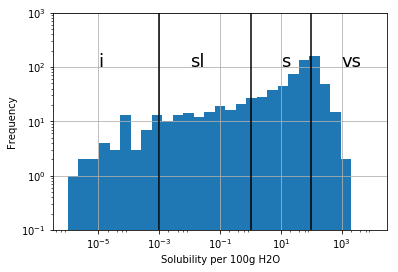

In [33]:
log_bins = np.logspace(-6, 4, num=30)
df.solubility_per_100gH2O.hist(bins=log_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Solubility per 100g H2O')
plt.ylabel('Frequency')
plt.vlines([1e-3, 1, 100], 1e-1, 1e3)
plt.ylim([1e-1, 1e3])
plt.text(1e-5, 1e2, 'i', fontsize=18)
plt.text(1e-2, 1e2, 'sl', fontsize=18)
plt.text(1e1, 1e2, 's', fontsize=18)
plt.text(1e3, 1e2, 'vs', fontsize=18)
plt.show()

Qualitative solubility limits:
* vs - very soluble - > 100g per 100g H2O
* s - soluble - 1-100g per 100g H2O
* sl - slightly soluble - 1e-3g - 1g per 100g H2O
* i - insoluble - less than 1e-3g per 100g H2O

Let's parse the qualitative solubility next. Where solubility is indicated, there is a marker (e.g. s for soluble, i for insoluble) followed by a list of solvents, then a semi-colon separator for listing other qualitative solubilities.

In [34]:
def parse_qualsol(qs_str):
    '''Parse a qualitative solubility string
    input - qs_str (string) - qualitative solubility string
    output - sols (dict) - dictionary with solvent as key, qualitative solubility as value
    '''
    sols = dict()
    for solubility in qs_str.split(';'): # First parse each solubility classifier
        items = solubility.strip().split(' ')
        qs = items[0]
        solvents = ' '.join(items[1:]).split(',')
        for solvent in solvents: # Then add each solvent
            # Clean up some spacing issues
            if ('H 4' in solvent or 'H 2' in solvent): solvent = solvent.replace('H ', 'H')
            sols[solvent.lstrip()] = qs
    return sols
            
qsseries = df.qualitative_solubility[df.qualitative_solubility.notnull()].apply(parse_qualsol)
td = dict()
for entry in qsseries:
    for key, value in entry.items():
        td.setdefault(key, []).append(value)
print(td.keys())

dict_keys(['H2O', 'acid', 'alk', 'EtOH', 'dil HCl', 'bz', 'tol', 'CS2', 'ctc', 'chl', 'eth', 'xyl', 'ace', 'pyr', 'os', 'peth', 'MeOH', 'py', 'et', 'ct', 'dil acid', 'conc HCl', 'hc', 'bz. tol', 'HNO3', 'diox', 'hot H2O', 'conc HNO3', 'HCl', 'alk iodide soln', 'H2O (exp)', 'NH4OH', 'conc acid', 'cold H2O', 'thf', 'hot acid', 'aqua regia', 'hot HCl', 'hot conc acid', 'KCN soln', 'conc alk', 'dil H2SO4', 'HOAc', 'CN soln', 'HF', 'dil HNO3', 'dil HF', 'hot EtOH', 'NaOH', 'dil acids', 'KCNS', 'warm acid', 'CC4l', 'dil alk', 'DMF', 'DMSO', 'sl aqua regia', 'EtOh', 'reac acid', 'H2SO4', 'of SO2 in H2O', 'HF-HNO3 mixture', 'hot conc alk', 'hot HF', 'HNO3/HF', 'eth chl', 'EtAc', 'bz chl', 'conc HF'])


Let's find the qualitative solubilities with the most entries to see whether we have enough data points to do anything useful.

In [35]:
nEntries = []
for key, value in td.items():
    nEntries.append((len(value), key))
sorted(nEntries, reverse=True)[:5]

[(1246, 'H2O'), (713, 'EtOH'), (233, 'acid'), (169, 'eth'), (121, 'ace')]

For now, let's only look at water solubility and leave other solubility to further analysis. Let's combine all of the water solubility information we have into a useful dataframe. We need to combine the quantitative solubility indicated in the column with the qualitative solubility indicated in the qualitative solubility column. We do this by sorting the quantitative value if given into its appropriate bin; if not given, we use the qualitative value.

In [36]:
df['is_hydrated'] = df.name.str.contains('hydrate')

In [37]:
df.head()

,no,name,chemical_formula,CAS_no,mol_weight,physical_form,melting_point,boiling_point,density,solubility_per_100gH2O,qualitative_solubility,is_hydrated
0,1,Actinium,Ac,7440-34-8,227,silv metal; cub,1051,3198,10,NaN,NaN,False
1,2,Actinium bromide,AcBr3,33689-81-5,467,wh hex cry,NaN,800 subl,5.85,NaN,s H2O,False
2,3,Actinium chloride,AcCl3,22986-54-5,333,wh hex cry,NaN,960 subl,4.81,NaN,NaN,False
3,4,Actinium fluoride,AcF3,33689-80-4,284,wh hex cry,NaN,NaN,7.88,NaN,i H2O,False
4,5,Actinium iodide,AcI3,33689-82-6,608,wh cry,NaN,NaN,NaN,NaN,s H2O,False


In [38]:
df['qs_H2O'] = -1 # Use -1 to indicate no information
solbins = [1e-3, 1, 100, 10000]
qs_conversion = {'vs': 3, 's': 2, 'sl': 1, 'i': 0, 'reac': -2}

for index, row in df.iterrows():
    # Otherwise use the qualitative solubility
    if type(row['qualitative_solubility']) is str and 'H2O' in row['qualitative_solubility']:
        soldict = parse_qualsol(row['qualitative_solubility'])
        if 'H2O' in soldict and soldict['H2O'] in qs_conversion:
            df.ix[index, 'qs_H2O'] = qs_conversion[soldict['H2O']]  
            
        #Use the quantitative solubility if given
    elif not np.isnan(row['solubility_per_100gH2O']):
        for solindex, limit in enumerate(solbins):
            if row['solubility_per_100gH2O'] < limit:
                df.ix[index, 'qs_H2O'] = solindex
                break
            

In [39]:
df[['name', 'solubility_per_100gH2O', 'qualitative_solubility', 'qs_H2O']][df.solubility_per_100gH2O.notnull()].head(10)

,name,solubility_per_100gH2O,qualitative_solubility,qs_H2O
19,Aluminum chloride,45.1,"s bz, ctc, chl",2
20,Aluminum chloride hexahydrate,45.1,"s EtOH, eth",2
23,Aluminum fluoride,0.5,NaN,1
24,Aluminum fluoride monohydrate,0.5,NaN,1
25,Aluminum fluoride trihydrate,0.5,NaN,1
34,Aluminum nitrate,68.9,vs EtOH; sl ace,2
35,Aluminum nitrate nonahydrate,68.9,vs EtOH; i pyr,2
43,Aluminum perchlorate nonahydrate,182.0,NaN,3
49,Aluminum sulfate,38.5,i EtOH,2
50,Aluminum sulfate octadecahydrate,38.5,NaN,2


In [40]:
df[['name', 'solubility_per_100gH2O', 'qualitative_solubility', 'qs_H2O']][df.qualitative_solubility.notnull()].head(10)

,name,solubility_per_100gH2O,qualitative_solubility,qs_H2O
1,Actinium bromide,NaN,s H2O,2
3,Actinium fluoride,NaN,i H2O,0
4,Actinium iodide,NaN,s H2O,2
5,Actinium oxide,NaN,i H2O,0
6,Aluminum,NaN,"i H2O; s acid, alk",0
7,Aluminum ammonium sulfate,NaN,sl H2O; i EtOH,1
8,Aluminum ammonium sulfate dodecahydrate,NaN,s H2O; i EtOH,2
11,Aluminum borate,NaN,i H2O,0
12,Aluminum boride,NaN,s dil HCl,-1
13,Aluminum borohydride,NaN,reac H2O,-2


What's the most common chemical precusor?

In [48]:
from collections import Counter
second_names = []
for index, chemical_name in df.name.items():
    splitnames = chemical_name.split(' ')
    if len(splitnames) > 1:
        second_names.extend(splitnames[1:])
name_counter = Counter(second_names)
print(name_counter.most_common(15))


[('chloride', 185), ('fluoride', 169), ('oxide', 146), ('bromide', 127), ('sulfate', 109), ('sulfide', 103), ('iodide', 98), ('hexahydrate', 87), ('nitrate', 80), ('dihydrate', 71), ('monohydrate', 62), ('hydrogen', 52), ('tetrahydrate', 50), ('trihydrate', 48), ('phosphate', 48)]


So it looks like we have lots of information on chlorides, fluorides, oxides, bromides, sulfates, sulfides, iodides, and nitrates. I work with nitrates quite a bit so I'll start there.

## Reading individual chemicals for plotting

In [ ]:
class Element:
    
    def __init__(self, name):
        '''Initialize relevant element info'''
        self.name = name
        self.atomic_number = get_atomic_number(name)
        self.row = get_row(atomic_number)
        self.col = get_group(atomic_number)
        
    
    def get_row(at_no):
        '''Get the (visual) row for a given element's atomic number
        input: at_no (int) - atomic number
        output: (int) - visual row'''
        if at_no < 3: return 1
        if at_no < 11: return 2
        if at_no < 19: return 3
        if at_no < 37: return 4
        if at_no < 55: return 5
        if at_no < 57: return 6
        if at_no < 72: return 9 # Lanthanides
        if at_no < 87: return 6
        if at_no < 89: return 7 
        if at_no < 104: return 10 # Actinides
        else: return 7
    
    def get_group(at_no):
        '''Get the (visual) column/group for a given element atomic number
        input: at_no (int) - atomic number
        output: (int) - visual column/group'''
        firsts = [1,3,11,19,37,55,87]
        if at_no in [1, 3, 11, 19, 37, 55, 87]: return 1
        if at_no in (firsts[1:] + 1): return 2
        for i in range(3, 13):
            if(at_no) in ( i): return i
        group_13 = [5, 13, 31, 49, 81, 113]
        
    def get_table_row():
        return (self.row - 1) * 2
    
    def get_table_col():
        return (self.col - 1) * 2
    
    

First, let's look at what types of chemicals we have.

In [ ]:

nitrates = df[df.name.str.contains(' nitrate')]
nitrates = nitrates[df.solubility_per_100gH2O.notnull() | df.qualitative_solubility.notnull()]
nitrates.name = nitrates.name.str.replace('nitrate (.+)hydrate', 'nitrate')
nitrates = nitrates.drop_duplicates(subset='name')
nitrates

Need to figure out a way to parse oxidation state from the name
Need to figure out a way to combine hydrate, non-hydrate information
Need to get group, period data for plotting

## Plotting
We can use the heatmap from the seaborn library to show our solubility information. This requires a little creative plotting to account for elements which have precursors with multiple oxidation states. We use a (2N, 2N) numpy ndarray to represent up to 4 possible oxidation states for each element. Then we mask over the periodic table and make some code to plot the qualitative solubility of an element belonging to a certain group of precursors (e.g. nitrates).

In [ ]:
import seaborn as sns

ptable = np.random.randn(20, 36)
mask = np.zeros_like(ptable)
mask[0:2,2:34] = True
mask[2:4,4:24] = True
mask[4:6,4:24] = True
mask[10:12,4:6] = True
mask[12:14,4:6] = True
mask[14:16,:] = True
mask[16:18,pd.np.r_[0:4,34:36]] = True
mask[18:20,pd.np.r_[0:4,34:36]] = True
with sns.axes_style("white"):
     ax = sns.heatmap(ptable, mask=mask, linewidths=0.1,vmax=.3, square=True, cbar=False, 
                      xticklabels=False, yticklabels=False)
plt.show()

For parsing out the oxidation state and hydration state, let's make a class called element that allows us to set some parameters